In [77]:
%load_ext autoreload
%autoreload 2

import os 
# os.environ['R_HOME']= r'C:\Users\tomha\miniconda3\envs\octagon_analysis\lib\R'
os.environ['R_HOME']= r'D:\Users\Tom\miniconda3\envs\octagon_analysis\lib\R'

import rpy2.robjects as robjects
print(robjects.r('R.version.string'))

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals
import data_strings
import data_extraction.get_indices as get_indices
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
from trajectory_analysis import trajectory_vectors
from plotting import plot_octagon
import parse_data.identify_filepaths as identify_filepaths 
from data_extraction.trial_list_filters import filter_trials_other_visible
from analysis import opponent_visibility


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[1] "R version 4.1.3 (2022-03-10)"



### Create a dataframe to feed into a GLM using D2H, D2L, First Seen, Wall Separation, and PlayerID (random effect) to predict P(Choose High)

In [78]:
data_folder = data_strings.DATA_FOLDER
json_filenames_social, json_filenames_solo = identify_filepaths.get_filenames()

In [79]:
# # restrict data for testing
# json_filenames_social = json_filenames_social[:8]
# json_filenames_solo = json_filenames_solo[:32]

In [80]:
df, trial_lists_social = prepare_data.prepare_data(data_folder, json_filenames_social, combine=False)

filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\240913_1\2024-09-13_11-31-00_YW13_JL13_Social.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\240927_1\2024-09-27_14-25-20_SH27_EN27_Social.json
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\241017_1\2024-10-17_14-28-40_SP17_AW17_Social.json
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\241017_2\2024-10-17_16-41-38_ZH17_EM17_Social.json
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\241112_1\2024-11-12_13-31-14_KA12_WM12_Social.json
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_jso

In [81]:
df, trial_lists_solo = prepare_data.prepare_data(data_folder, json_filenames_solo, combine=False)

filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\240913_1\2024-09-13_11-23-37_YW13_FirstSolo.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\240913_1\2024-09-13_11-53-34_YW13_SecondSolo.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\240913_1\2024-09-13_11-23-50_JL13_FirstSolo.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: C:\Users\tomha\OneDrive\PhD\SWC\data\pseudonymised_json_files\240913_1\2024-09-13_11-53-56_JL13_SecondSolo.json
Data is from period before 2024-09-13 00:00:00
Running 

In [82]:
# create a list of combined pre- and post- social solo sessions, removing 5 trials from each pre
trial_lists_combined_solo = []
cut_trials = 5
for i in range(0,len(trial_lists_solo), 2): # iterate over each individual
    # get the trial lists for both solo sessions
    trial_list_first_solo = trial_lists_solo[i]
    trial_list_second_solo = trial_lists_solo[i + 1]

    # cut first cut_trials trials (learning controls/associations) from the first solo
    trial_list_first_solo = trial_list_first_solo[cut_trials:]

    # combine trial lists from the first and second solo sessions (the current and consecutive index)
    trial_list = trial_list_first_solo + trial_list_second_solo

    trial_lists_combined_solo.append(trial_list)


In [83]:
len(trial_lists_combined_solo), len(trial_lists_social)

(70, 35)

### Regressor value extraction functions (for one session)

In [84]:
def extract_wall_sep(trial_list):
    ''' Return wall separation for one session.
        1 for 45 degrees, 2 for 90 and 4 for 180. '''
    
    wall_sep = np.full(len(trial_list), np.nan)
    for i, trial in enumerate(trial_list):
        wall_sep_this_trial = get_indices.get_wall_difference(trial=trial)
        wall_sep[i] = wall_sep_this_trial

    return wall_sep


def extract_first_wall_seen(trial_list, player_id):
    ''' Return first visible walls for one player across one session.
        1 for WALL_1, 2 for WALL_2, np.nan for no visible wall (or both initially visible). '''
        
    high_wall_first_visible_session = wall_visibility_and_choice.get_given_wall_first_visible_session(trial_list,
                                                                                                        player_id,
                                                                                                        wall_index=0,
                                                                                                        current_fov=110)

    low_wall_first_visible_session = wall_visibility_and_choice.get_given_wall_first_visible_session(trial_list,
                                                                                                        player_id, 
                                                                                                        wall_index=1,
                                                                                                        current_fov=110)
    low_wall_first_visible_session = low_wall_first_visible_session*2
    
    first_visible_session = high_wall_first_visible_session + low_wall_first_visible_session

    first_visible_session[first_visible_session == 0] = np.nan

    return first_visible_session

# double check code
def extract_distances_to_walls(trial_list, player_id, normalise=False):
    ''' Return a trial_num, 2 sized array, where column 1
        is distance to WALL_1, and column 2 is distance to WALL_2.
        Data applies to one full session, and specified player_id.
        If normalise, returns distances as a proportion of the maximum
        possible in the arena '''
    
    # get octagon alcove coordinates
    alcove_coordinates = plot_octagon.return_alcove_centre_points()

    positions_session = np.full((len(trial_list), 2), np.nan)
    walls_session = np.full((len(trial_list), 2), np.nan)
    distances_session = np.full((len(trial_list), 2), np.nan)

    # get distances for each trial in the session
    for i, trial in enumerate(trial_list):
        # get WALL_1 and WALL_2 coordinates
        trial_walls = get_indices.get_walls(trial)
        high_wall_idx = trial_walls[0] - 1
        low_wall_idx = trial_walls[1] - 1
        trial_high_coordinates = alcove_coordinates[:,high_wall_idx]
        trial_low_coordinates = alcove_coordinates[:, low_wall_idx]

        # index trajectory at timepoint 0 to get player starting coordinates
        trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=player_id)
        trial_start_position = trajectory[:,0]

        # find distance between start position and WALL_1/WALL_2
        d2h = np.linalg.norm(trial_high_coordinates - trial_start_position) # WALL_1
        d2l = np.linalg.norm(trial_low_coordinates - trial_start_position) # WALL_2

        walls_session[i,:] = trial_walls 
        positions_session[i,:] = trial_start_position
        distances_session[i,:] = np.hstack((d2h, d2l))

    # normalise to maximum possible distance in octagon
    if normalise:
        distances_session = distances_session/plot_octagon.return_maximum_distance()

    return distances_session


def extract_opponent_visibility_slice_onset(trial_list, player_id, current_fov=110):
    ''' Return opponent visibility at slice onset for one player for one session.
        1 for opponent visible, 0 for opponent not visible '''
    
    # slice onset angle of Other from self centre FoV
    orientation_angle_to_other_session = opponent_visibility.get_angle_of_opponent_from_player_session(player_id, trial_list)

    # boolean array of Other visible
    other_visible_session = opponent_visibility.get_other_visible_session(orientation_angle_to_other_session, current_fov)
    other_visible_session = other_visible_session.astype(int) # converted to int for categorical regressor

    # does this return 1 and 0? 

    return other_visible_session


def extract_player_choice(trial_list, player_id, inferred_choice=True, debug=True):
    ''' Return (inferred by default) player choice for one player for one session.
        Where inferred and actual choice are both missing, values are np.nan '''

    # array of wall numbers where player choice is available, np.nan where it is not
    player_choice = wall_visibility_and_choice.get_player_wall_choice(trial_list, player_id,
                                                                        inferred_choice=inferred_choice, debug=debug)

    # 2 where player chose High, 0 where player chose Low, np.nan where lacking inferred choice
    high_wall_chosen_session = get_indices.was_given_wall_chosen(trial_list, player_choice,
                                                                    given_wall_index=0)
    high_wall_chosen_session = high_wall_chosen_session*2
    print(f"High wall chosen session:\n{high_wall_chosen_session}")

    # 1 where player chose Low, 0 where player chose High, np.nan where lacking inferred choice
    low_wall_chosen_session  = get_indices.was_given_wall_chosen(trial_list, player_choice,
                                                                    given_wall_index=1)
    
    print(f"Low wall chosen session:\n{low_wall_chosen_session}")

    # 1 or 2 where player chose Low or High respectively, np.nan where lacking inferred choice
    chosen_wall_session = high_wall_chosen_session + low_wall_chosen_session

    print(f"Overall chosen wall for this session:\n{chosen_wall_session}")

    # Does this switch to 0 or 1 respectively and np.nan? 
    chosen_wall_session = chosen_wall_session -1 

    return chosen_wall_session


def extract_trial_outcome(trial_list, player_id):
    ''' Return whether this player won the trial for one player for one session '''
    
    trigger_activators = get_indices.get_trigger_activators(trial_list)
    this_player_won_session = (trigger_activators-1)*-1 if player_id == 0 else trigger_activators

    return this_player_won_session

In [ ]:
# np.sum(~np.isnan(test))/test.size

np.float64(0.6534090909090909)

#### Filtering function

In [85]:
def filter_nans_from_trial_list(data, original_indices, debug=False):
    
    # mask non-nan values in the data and check that the sizes match
    valid_data_mask = ~np.isnan(data)
    original_indices = original_indices[valid_data_mask[original_indices]]

    if debug:
        print(f"{np.sum(valid_data_mask)} valid datapoints")


    return original_indices, valid_data_mask

In [86]:
def filter_valid_trial_indices(trial_list, player_id, solo=False, include_opponent_first_seen_wall=False, return_filtered_data=True, debug=False):
    ''' Return the indices of a filtered trial list that correspond to trials in which there is a 
        retrievable choice and an identifiable first seen wall (for self, or both).
        At each filtering step, identify the original trial list indices that remain.
        Optionally, return the filtered data used (player choice, first wall seen).
        If specified, include the opponent's first wall seen in this analysis as well. '''

    opponent_id = 1 if player_id == 0 else 0

    original_indices = np.arange(len(trial_list))

    # identify indices of trial list with HighLow trials
    high_low_trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=globals.HIGH_LOW)
    original_indices = original_indices[high_low_trial_indices]
    # trial_list_filtered = [trial_list[i] for i in high_low_trial_indices]
    print(f"{high_low_trial_indices.size} high_low_trial_indices for player_id {player_id}")


    # get choice and first visible wall data for one player, session
    if not solo:
        player_choice_session = extract_player_choice(trial_list, player_id)
    else:
        player_choice_session = extract_player_choice(trial_list, player_id, inferred_choice=False)
    
    # apply masks for one visible wall and a retrievable choice to the set of HighLow trials
    (original_indices,
      retrievable_choice_mask) = filter_nans_from_trial_list(player_choice_session, original_indices)
    print(f"{np.sum(retrievable_choice_mask)} retrievable choices for player_id {player_id}")
    
    first_wall_seen_session = extract_first_wall_seen(trial_list, player_id)
    (original_indices,
      one_wall_first_visible_mask) = filter_nans_from_trial_list(first_wall_seen_session, original_indices)
    print(f"{np.sum(one_wall_first_visible_mask)} first visible walls for player_id {player_id}")


    if include_opponent_first_seen_wall:
        first_wall_seen_session_opponent = extract_first_wall_seen(trial_list, opponent_id)
        (original_indices,
        opponent_one_wall_first_visible_mask) = filter_nans_from_trial_list(first_wall_seen_session_opponent, original_indices)
        print(f"{np.sum(opponent_one_wall_first_visible_mask)} first visible walls for both players")

    # # combine masks
    # final_mask = retrievable_choice_mask & one_wall_first_visible_mask

    # # filter the trial list and analysis based on masks
    # filtered_indices = high_low_trial_indices[final_mask]
    player_choice_filtered = player_choice_session[original_indices]
    one_wall_first_visible_filtered = first_wall_seen_session[original_indices]
    if include_opponent_first_seen_wall:
        opponent_one_wall_first_visible_filtered = first_wall_seen_session_opponent[original_indices]

    assert original_indices.size > 0
    
    print(f"{original_indices.size} filtered trials for player_id {player_id}")
    
    if return_filtered_data and include_opponent_first_seen_wall:
        return original_indices, player_choice_filtered, one_wall_first_visible_filtered, opponent_one_wall_first_visible_filtered
    elif return_filtered_data:
        return  original_indices, player_choice_filtered, one_wall_first_visible_filtered
    else:
        return original_indices

### Create a dictionary to hold, for each session and player, regressor values for the session, only including trials with fully-populated regessors
- Fields for each of the regressors applied to all trials
- Fields for each of the regressors with only valid trials


In [87]:
solo = False
player_ids = [0] if solo else [0,1]


In [88]:
analysis_results = {
    experiment_id: {
        player_id: {
            session_type: {

                'regressors': {
                    'wall_sep': None,
                    'first_seen': None,
                    'd2h': None,
                    'd2l': None,
                    'opponent_visible': None,
                    'd2h_opponent': None,
                    'd2l_opponent': None
                },

                'dependent': {
                    'choice': None
                },

                'misc': {
                    'valid_trial_indices': None
                }
                
            }
            for session_type in ['solo', 'social']
        }   
        for player_id in player_ids
    }
    for experiment_id in np.arange(len(trial_lists_social))
}

### Populate the dictionary with data

In [89]:
opponent_first_seen_wall = False

In [ ]:
for experiment_id, players in analysis_results.items():
    for player_id, data in players.items():
        
        # get opponent_id
        opponent_id = 1 if player_id == 0 else 0
        
        # get the trial lists for this session and player
        trial_list_social = trial_lists_social[experiment_id]
        trial_list_solo = trial_lists_combined_solo[experiment_id*2 + player_id] # player_id used to select correct solo

        # filter the trial list for trials with valid data for all regressors
        print(f"Trial list social length for experimentId {experiment_id} and playerId {player_id}: {len(trial_list_social)}")
        if opponent_first_seen_wall:
          (filtered_valid_trial_indices_social,
            filtered_retrievable_choice_social,
            filtered_first_wall_seen_social,
            filtered_opponent_first_wall_seen_social) = filter_valid_trial_indices(trial_list_social, player_id, include_opponent_first_seen_wall=True)
        else:
          (filtered_valid_trial_indices_social,
            filtered_retrievable_choice_social,
            filtered_first_wall_seen_social) = filter_valid_trial_indices(trial_list_social, player_id, include_opponent_first_seen_wall=False)
        trial_list_social_filtered = [trial_list_social[i] for i in filtered_valid_trial_indices_social]
        
        (filtered_valid_trial_indices_solo,
          filtered_retrievable_choice_solo,
          filtered_first_wall_seen_solo) = filter_valid_trial_indices(trial_list_solo, player_id=0, solo=True)  # no inferred for solo
        trial_list_solo_filtered = [trial_list_solo[i] for i in filtered_valid_trial_indices_solo]
        
        ## social, use player_id == player_id and trial_list_social_filtered for functions
        # regressors social
        player_data = analysis_results[experiment_id][player_id]['social']
        distances = extract_distances_to_walls(trial_list_social_filtered, player_id, normalise=True)
        distances_opponent = extract_distances_to_walls(trial_list_social_filtered, player_id=opponent_id, normalise=True)
        player_data['regressors']['wall_sep'] = extract_wall_sep(trial_list_social_filtered)
        player_data['regressors']['first_seen'] = filtered_first_wall_seen_social
        player_data['regressors']['d2h'] = distances[:,0]
        player_data['regressors']['d2l'] = distances[:,1]
        player_data['regressors']['opponent_visible'] = extract_opponent_visibility_slice_onset(trial_list_social_filtered, player_id)
        player_data['regressors']['d2h_opponent'] = distances_opponent[:,0]
        player_data['regressors']['d2l_opponent'] = distances_opponent[:,1]
        if opponent_first_seen_wall:
          player_data['regressors']['first_seen_opponent'] = filtered_opponent_first_wall_seen_social

        # dependent variable social
        player_data['dependent']['choice'] = filtered_retrievable_choice_social

        # misc
        player_data['misc']['valid_trial_indices'] = filtered_valid_trial_indices_social


        ## solo, use player_id == 0 and trial_list_solo_filtered for functions
        # regressors solo
        player_data = analysis_results[experiment_id][player_id]['solo']
        distances = extract_distances_to_walls(trial_list_solo_filtered, player_id=0, normalise=True)
        player_data['regressors']['wall_sep'] = extract_wall_sep(trial_list_solo_filtered)
        player_data['regressors']['first_seen'] = filtered_first_wall_seen_solo
        player_data['regressors']['d2h'] = distances[:,0]
        player_data['regressors']['d2l'] = distances[:,1]

        # dependent variable solo
        player_data['dependent']['choice'] = filtered_retrievable_choice_solo # no inferred for solo






In [ ]:
# # run through the dictionary again, adding d2l, d2h, and first_visible for the opponent in social
# for experiment_id, players in analysis_results.items():
#     for player_id, data in players.items():
        
#         trial_list_social = trial_lists_social[experiment_id]

#         opponent_player_id = 1 if player_id == 0 else 0

#         player_data = analysis_results[experiment_id][player_id]['social']
#         opponent_data = analysis_results[experiment_id][opponent_player_id]['social']

#         valid_indices_self = player_data['misc']['valid_trial_indices']
#         valid_indices_opponent = opponent_data['misc']['valid_trial_indices']
#         valid_indices_all = np.intersect1d(valid_indices_self, valid_indices_opponent)

#         trial_list_social_filtered = trial_list_social
#         player_data['regressors']['d2h_opponent'] = 




In [90]:
import pickle

# with open('analysis_results.pkl', 'wb') as f:
#     pickle.dump(analysis_results, f)


with open('analysis_results_opponent_first_vis_wall.pkl', 'rb') as f:
    analysis_results = pickle.load(f)

#### Populate a dataframe, with a row for each trial, and fields for regressors (only including trials with fully-populated regressors)

In [91]:
glm_df_social = pd.DataFrame()

for session_id, players in analysis_results.items():
    for player_id in players:
        
        # take each filtered_regressor array and fill the relevant df field for this player
        player_data = analysis_results[session_id][player_id]['social']['regressors']
        choice = analysis_results[session_id][player_id]['social']['dependent']['choice']
        opponent_player_id = 1 if player_id == 0 else 1
        opponent_player_data = analysis_results[session_id][opponent_player_id]['social']['regressors']
        df_player = pd.DataFrame(
                    {
                        "SessionID" : session_id,
                        "PlayerID" : player_id,
                        "GlmPlayerID" : session_id*2 + player_id,
                        "ChooseHigh" : choice,
                        "WallSep" : player_data['wall_sep'],
                        "FirstSeenWall" : player_data['first_seen'],
                        "D2H" : player_data['d2h'],
                        "D2L" : player_data['d2l'],
                        "OpponentVisible" : player_data['opponent_visible'],
                        "OpponentFirstSeenWall" : player_data['first_seen_opponent'],
                        "OpponentD2H" : player_data['d2h_opponent'],
                        "OpponentD2L" : player_data['d2l_opponent']
                        
                    }
        )


        # append this smaller dataframe to the the full dataframe
        glm_df_social = pd.concat([glm_df_social, df_player], ignore_index=True)



glm_df_social["FirstSeenWall"] = glm_df_social["FirstSeenWall"].astype("category")
glm_df_social["OpponentFirstSeenWall"] = glm_df_social["OpponentFirstSeenWall"].astype("category")

glm_df_social["WallSep"] = glm_df_social["WallSep"].astype("category")

In [92]:
glm_df_solo = pd.DataFrame()

for session_id, players in analysis_results.items():
    for player_id in players:
        
        # take each filtered_regressor array and fill the relevant df field for this player
        player_data = analysis_results[session_id][player_id]['solo']['regressors']
        choice = analysis_results[session_id][player_id]['solo']['dependent']['choice']
        df_player = pd.DataFrame(
                    {
                        "SessionID" : session_id,
                        "PlayerID" : player_id,
                        "GlmPlayerID" : session_id*2 + player_id,
                        "ChooseHigh" : choice,
                        "WallSep" : player_data['wall_sep'],
                        "FirstSeenWall" : player_data['first_seen'],
                        "D2H" : player_data['d2h'],
                        "D2L" : player_data['d2l']
                    }
        )

        # append this smaller dataframe to the the full dataframe
        glm_df_solo = pd.concat([glm_df_solo, df_player], ignore_index=True)


glm_df_solo["FirstSeenWall"] = glm_df_solo["FirstSeenWall"].astype("category")
glm_df_solo["WallSep"] = glm_df_solo["WallSep"].astype("category")

#### GLM Code in Pymer4

In [153]:
!R --version


R version 4.1.3 (2022-03-10) -- "One Push-Up"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
https://www.gnu.org/licenses/.



In [56]:
from pymer4.models import Lmer
import pandas as pd

df = pd.DataFrame({
    "y": [0, 1, 0, 1, 1, 0],
    "x": [1, 2, 3, 4, 5, 6],
    "group": ["A", "A", "B", "B", "C", "C"]
})

model = Lmer("y ~ x + (1|group)", data=df, family='binomial')
model.fit()

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: y~x+(1|group)

Family: binomial	 Inference: parametric

Number of observations: 6	 Groups: {'group': 3.0}

Log-likelihood: -4.130 	 AIC: 14.260

Random effects:

              Name  Var  Std
group  (Intercept)  0.0  0.0

No random effect correlations specified

Fixed effects:



d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.402,-4.079,3.275,1.876,0.669,0.017,26.442,0.401,0.017,0.964,-0.214,0.830,
x,0.115,-0.830,1.060,0.482,1.122,0.436,2.886,0.529,0.304,0.743,0.238,0.812,


In [189]:
glm_df_social['D2L'][400:450]

400    0.419381389
401    0.429714872
402    0.485201508
403    0.504275440
404    0.474882412
405    0.488361285
406    0.461464716
407    0.521760859
408    0.521238598
409    0.442981369
410    0.420292958
411    0.504933666
412    0.483187180
413    0.469368054
414    0.474946011
415    0.510534278
416    0.444974655
417    0.233873499
418    0.753820671
419    0.478438405
420    0.684599188
421    0.179522932
422    0.531362948
423    0.769456582
424    0.400132846
425    0.250594520
426    0.767738527
427    0.135090249
428    0.280934228
429    0.620218431
430    0.881968528
431    0.592010514
432    0.386479316
433    0.334076467
434    0.461549351
435    0.613871707
436    0.384537857
437    0.485193985
438    0.538645295
439    0.585552060
440    0.457937774
441    0.532349972
442    0.625576495
443    0.444776468
444    0.350349106
445    0.496634297
446    0.617478702
447    0.520607409
448    0.445109717
449    0.358078140
Name: D2L, dtype: float64

In [ ]:
# glm_df_solo_switch = glm_df_solo
# glm_df_solo_switch['FirstSeenWall'] = glm_df_solo['FirstSeenWall'].apply(lambda x: 3 - x)
# glm_df_solo["FirstSeenWall"] = glm_df_solo["FirstSeenWall"].astype("category")
# glm_df_social["WallSep"] = glm_df_social["WallSep"].astype("category")

In [ ]:
# glm_df_social_switch = glm_df_social
# glm_df_social_switch[['FirstSeenWall','OpponentFirstSeenWall']] = glm_df_social[['FirstSeenWall','OpponentFirstSeenWall']].apply(lambda x: 3 - x)
# glm_df_social["FirstSeenWall"] = glm_df_social["FirstSeenWall"].astype("category")
# glm_df_social["OpponentFirstSeenWall"] = glm_df_social["OpponentFirstSeenWall"].astype("category")

# glm_df_social["WallSep"] = glm_df_social["WallSep"].astype("category")

In [93]:
glm_df_social['D2L']

0       0.163732625
1       0.667644628
2       0.207976166
3       0.667321336
4       0.307341935
           ...     
2811    0.863577505
2812    0.921859677
2813    0.334038351
2814    0.014218477
2815    0.321536590
Name: D2L, Length: 2816, dtype: float64

In [ ]:
# dist = plot_octagon.return_maximum_distance()

# glm_df_social['D2L'] = glm_df_social['D2L']*dist
# glm_df_social['D2H'] = glm_df_social['D2H']*dist
# glm_df_social['OpponentD2H'] = glm_df_social['OpponentD2H']*dist
# glm_df_social['OpponentD2L'] = glm_df_social['OpponentD2L']*dist


In [97]:
zscore = True
if zscore:
    glm_df_social["D2H_z"] = (glm_df_social["D2H"] - glm_df_social["D2H"].mean())/glm_df_social["D2H"].std()
    glm_df_social["D2L_z"] = (glm_df_social["D2L"] - glm_df_social["D2L"].mean())/glm_df_social["D2L"].std()
    glm_df_social["OpponentD2H_z"] = (glm_df_social["OpponentD2H"] - glm_df_social["OpponentD2H"].mean())/glm_df_social["OpponentD2H"].std()
    glm_df_social["OpponentD2L_z"] = (glm_df_social["OpponentD2L"] - glm_df_social["OpponentD2L"].mean())/glm_df_social["OpponentD2L"].std()

    glm_df_solo["D2H_z"] = (glm_df_solo["D2H"] - glm_df_solo["D2H"].mean())/glm_df_solo["D2H"].std()
    glm_df_solo["D2L_z"] = (glm_df_solo["D2L"] - glm_df_solo["D2L"].mean())/glm_df_solo["D2L"].std()



In [105]:
from pymer4.models import Lmer

# model_formula = 'ChooseHigh ~ D2H_z + D2L_z + FirstSeenWall + WallSep + (1|GlmPlayerID)'
model_formula = 'ChooseHigh ~ D2H_z + D2L_z + FirstSeenWall + WallSep + ( FirstSeenWall | GlmPlayerID)'
# model_formula = 'ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + (1 + D2H + D2L + FirstSeenWall || GlmPlayerID)'


model = Lmer(model_formula, data=glm_df_solo, family='binomial')
results=model.fit()

print(results)

c:\Users\tomha\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "WallSep". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
c:\Users\tomha\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "FirstSeenWall". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~D2H_z+D2L_z+FirstSeenWall+WallSep+(FirstSeenWall|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 3211	 Groups: {'GlmPlayerID': 70.0}

Log-likelihood: -913.960 	 AIC: 1845.919

Random effects:

                         Name    Var    Std
GlmPlayerID       (Intercept)  4.199  2.049
GlmPlayerID  FirstSeenWall2.0  3.543  1.882

                     IV1               IV2   Corr
GlmPlayerID  (Intercept)  FirstSeenWall2.0 -0.732

Fixed effects:

                  Estimate  2.5_ci  97.5_ci     SE       OR  OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig
(Intercept)          6.147   5.154    7.141  0.507  467.528    173.190    1262.098  0.998        0.994         0.999  12.133   0.00  ***
D2H_z               -0.024  -0.161    0.113  0.070    0.976      0.851       1.120  0.494        0.460         0.528  -0.346   0.73     
D2L_z                0.473   0.334   

c:\Users\tomha\miniconda3\envs\octagon_analysis\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
c:\Users\tomha\miniconda3\envs\octagon_analysis\Lib\site-packages\pymer4\models\Lmer.py:744: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_corrs = ran_corrs.applymap(


In [ ]:
print(results)

                  Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val Sig
(Intercept)         -0.112  -0.458    0.234  0.176  0.894      0.633       1.263  0.472        0.388         0.558  -0.635  0.525    
D2H                  0.011  -0.001    0.023  0.006  1.011      0.999       1.023  0.503        0.500         0.506   1.859  0.063   .
D2L                 -0.005  -0.016    0.007  0.006  0.995      0.984       1.007  0.499        0.496         0.502  -0.787  0.431    
FirstSeenWall2.0    -0.029  -0.184    0.125  0.079  0.971      0.832       1.133  0.493        0.454         0.531  -0.371  0.711    
WallSep2.0           0.036  -0.148    0.221  0.094  1.037      0.862       1.247  0.509        0.463         0.555   0.385  0.700    
WallSep4.0           0.031  -0.149    0.212  0.092  1.032      0.862       1.236  0.508        0.463         0.553   0.342  0.733    


In [109]:
from pymer4.models import Lmer

# model_formula = 'ChooseHigh ~ D2H_z + D2L_z + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H_z + OpponentD2L_z + OpponentFirstSeenWall + (1|GlmPlayerID)'
model_formula = 'ChooseHigh ~ D2H_z + D2L_z + FirstSeenWall + WallSep + OpponentD2H_z + OpponentD2L_z + OpponentFirstSeenWall + (1 + FirstSeenWall + D2H_z + D2L_z | GlmPlayerID)'
# model_formula = 'ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + (D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall| GlmPlayerID)'
# model_formula = 'ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + (1 + D2H + D2L + FirstSeenWall + OpponentVisible + OpponentD2H + OpponentD2L || GlmPlayerID)'


model = Lmer(model_formula, data=glm_df_social, family='binomial')
results=model.fit()

print(results)

c:\Users\tomha\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "WallSep". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
c:\Users\tomha\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "FirstSeenWall". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
c:\Users\tomha\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "OpponentFirstSeenWall". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when 

Model failed to converge with max|grad| = 0.0478626 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~D2H_z+D2L_z+FirstSeenWall+WallSep+OpponentD2H_z+OpponentD2L_z+OpponentFirstSeenWall+(1+FirstSeenWall+D2H_z+D2L_z|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 2816	 Groups: {'GlmPlayerID': 70.0}

Log-likelihood: -1171.902 	 AIC: 2381.805

Random effects:

                         Name    Var    Std
GlmPlayerID       (Intercept)  0.491  0.701
GlmPlayerID  FirstSeenWall2.0  1.357  1.165
GlmPlayerID             D2H_z  0.229  0.479
GlmPlayerID             D2L_z  0.138  0.371

                          IV1               IV2   Corr
GlmPlayerID       (Intercept)  FirstSeenWall2.0 -0.502
GlmPlayerID       (Intercept)             D2H_z  0.467
GlmPlayerID       (Intercept)             D2L_z -0.024
GlmPlayerID  FirstSeenWall2.0             D2H_z -0.110
GlmPlayerID  FirstSeenWall2.0             D2L_z  0.143
G

c:\Users\tomha\miniconda3\envs\octagon_analysis\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
c:\Users\tomha\miniconda3\envs\octagon_analysis\Lib\site-packages\pymer4\models\Lmer.py:744: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_corrs = ran_corrs.applymap(


#### Checking colinearity

In [135]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import re

# begin at start (^), lazily match any character any number of times ((.*?)), lazy non-matching group for space, +, space ((?:\s+\s)?), an opening parenthesis (\()
pattern = r'^(.*?)(?:\s\+\s)?\('
match = re.match(pattern, model_formula)
formula = match.group(1)
# formula = 'ChooseHigh ~ D2L + D2H + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall' # only including fixed effects
y, X = dmatrices(formula, data=glm_df_social, return_type='dataframe')

# compute VIF (variance inflation factor)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]

print(vif_data)

                        feature          VIF
0                     Intercept  5.323574038
1          FirstSeenWall[T.2.0]  1.038284203
2                WallSep[T.2.0]  1.366991113
3                WallSep[T.4.0]  1.390956676
4  OpponentFirstSeenWall[T.2.0]  1.065038074
5                         D2H_z  1.098538514
6                         D2L_z  1.075495108
7                 OpponentD2H_z  1.061385066
8                 OpponentD2L_z  1.034705726


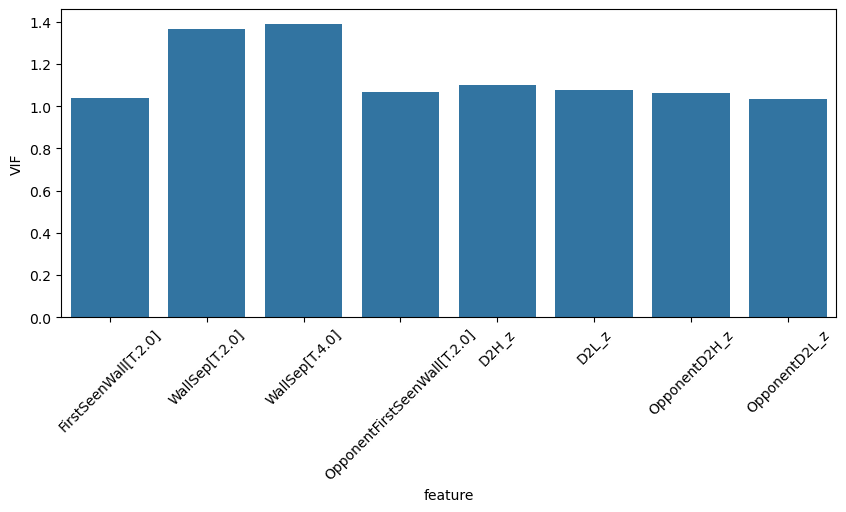

In [142]:
import seaborn as sns

plt.figure(figsize=(10,4))
sns.barplot(data=vif_data, x=vif_data['feature'].iloc[1:], y=vif_data['VIF'].iloc[1:])
plt.tick_params(axis='x', rotation=45)


In [107]:
glm_df_social[['D2L','D2H','FirstSeenWall', 'WallSep', 'OpponentVisible','OpponentD2H', 'OpponentD2L', 'OpponentFirstSeenWall']].corr()

,D2L,D2H,FirstSeenWall,WallSep,OpponentVisible,OpponentD2H,OpponentD2L,OpponentFirstSeenWall
D2L,1.000000000,-0.232650188,0.116286512,0.065069491,-0.034636722,-0.024552826,-0.017264985,-0.041902940
D2H,-0.232650188,1.000000000,-0.171425690,0.097958451,-0.042085673,0.013413734,-0.000967017,0.029674447
FirstSeenWall,0.116286512,-0.171425690,1.000000000,0.011938701,0.019013269,-0.004543673,-0.016809303,-0.016183376
WallSep,0.065069491,0.097958451,0.011938701,1.000000000,-0.016109125,0.031139224,0.036524326,0.004250822
OpponentVisible,-0.034636722,-0.042085673,0.019013269,-0.016109125,1.000000000,0.106370346,0.097371275,-0.003502079
OpponentD2H,-0.024552826,0.013413734,-0.004543673,0.031139224,0.106370346,1.000000000,-0.131130125,-0.211492279
OpponentD2L,-0.017264985,-0.000967017,-0.016809303,0.036524326,0.097371275,-0.131130125,1.000000000,0.143552624
OpponentFirstSeenWall,-0.041902940,0.029674447,-0.016183376,0.004250822,-0.003502079,-0.211492279,0.143552624,1.000000000


In [52]:
print(results)

                  Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig
(Intercept)          3.204   2.774    3.634  0.219  24.638     16.025      37.879  0.961        0.941         0.974  14.601  0.000  ***
D2H                 -0.081  -0.094   -0.067  0.007   0.922      0.910       0.935  0.480        0.476         0.483 -11.807  0.000  ***
D2L                 -0.072  -0.086   -0.058  0.007   0.931      0.918       0.944  0.482        0.479         0.486 -10.011  0.000  ***
FirstSeenWall2.0    -0.186  -0.328   -0.044  0.072   0.830      0.721       0.957  0.454        0.419         0.489  -2.567  0.010    *
WallSep2.0           0.125  -0.047    0.298  0.088   1.134      0.954       1.347  0.531        0.488         0.574   1.423  0.155     
WallSep4.0           0.145  -0.022    0.311  0.085   1.156      0.978       1.365  0.536        0.495         0.577   1.703  0.088    .


#### Plotting random slopes

In [133]:
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),3.303827610,2.921139414,3.686515806,0.195252667,27.216614380,18.562425697,39.905565705,0.964559887,0.948881595,0.975553449,16.920780926,3.162098302e-64,***
D2H_z,-0.334400076,-0.523738810,-0.145061341,0.096603170,0.715767364,0.592301899,0.864969233,0.417170404,0.371978391,0.463798125,-3.461584898,5.370047177e-04,***
D2L_z,0.538764405,0.369905024,0.707623787,0.086154329,1.713887883,1.447597121,2.029163800,0.631524940,0.591436029,0.669875891,6.253480382,4.014050085e-10,***
FirstSeenWall2.0,-3.726551502,-4.155884573,-3.297218431,0.219051510,0.024075718,0.015671922,0.036985903,0.023509705,0.015430103,0.035666737,-17.012215519,6.666824894e-65,***
WallSep2.0,-0.738654226,-1.025994902,-0.451313551,0.146605079,0.477756435,0.358439676,0.636791144,0.323298497,0.263861312,0.389048503,-5.038394510,4.694530407e-07,***
WallSep4.0,-1.307668145,-1.584516669,-1.030819621,0.141251842,0.270449972,0.205046875,0.356714470,0.212877309,0.170156762,0.262925234,-9.257706815,2.088697621e-20,***
OpponentD2H_z,0.155224236,0.039263283,0.271185189,0.059164839,1.167919821,1.040044274,1.311517926,0.538728328,0.509814560,0.567383844,2.623589272,8.700863981e-03,**
OpponentD2L_z,-0.054868228,-0.168627952,0.058891496,0.058041742,0.946609876,0.844823159,1.060660149,0.486286383,0.457942625,0.514718620,-0.945323586,3.444937005e-01,
OpponentFirstSeenWall2.0,0.325185984,0.099164489,0.551207478,0.115319208,1.384288077,1.104247921,1.735347148,0.580587594,0.524770827,0.634415690,2.819877007,4.804205944e-03,**


In [ ]:
model.coefs.loc['D2H_z', 'Estimate']

np.float64(-0.3344000756233435)

In [129]:
model.fixef.iloc[0]

(Intercept)                 3.401665461
D2H_z                      -0.310557401
D2L_z                       0.470316995
FirstSeenWall2.0           -4.446692254
WallSep2.0                 -0.738654226
WallSep4.0                 -1.307668145
OpponentD2H_z               0.155224236
OpponentD2L_z              -0.054868228
OpponentFirstSeenWall2.0    0.325185984
Name: 0, dtype: float64

C:\Users\tomha\AppData\Local\Temp\ipykernel_23828\3457369400.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_df, x='GlmPlayerID', y=slope, ax=ax, palette='coolwarm')
C:\Users\tomha\AppData\Local\Temp\ipykernel_23828\3457369400.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_df, x='GlmPlayerID', y=slope, ax=ax, palette='coolwarm')
C:\Users\tomha\AppData\Local\Temp\ipykernel_23828\3457369400.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_df, x='GlmPlayerID', y=slope, ax=ax, palette='coolwarm'

<function matplotlib.pyplot.show(close=None, block=None)>

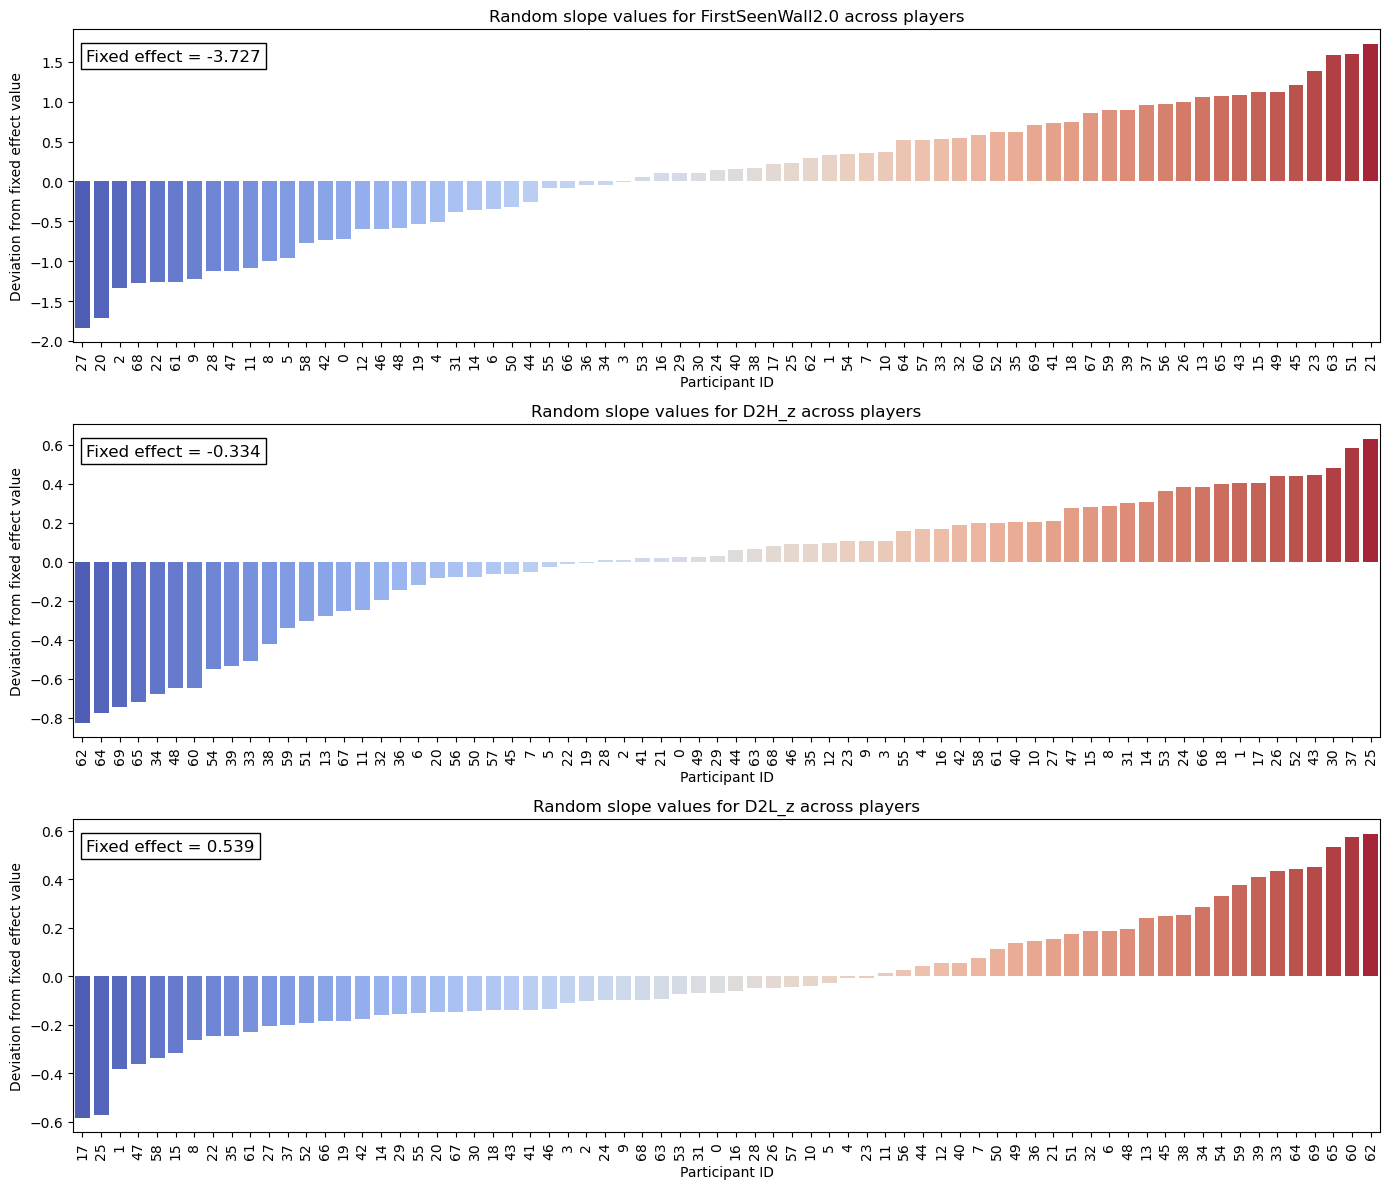

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming ranefs is your wide-format DataFrame
re_df = model.ranef.copy()

# Optional: Add participant IDs as a proper column if they're in the index
re_df['GlmPlayerID'] = re_df.index

# Define slopes to plot and extract fixed effects
slope_vars = ['FirstSeenWall2.0', 'D2H_z', 'D2L_z']
fixed_effects_coefs = model.coefs  # Returns a DataFrame with Estimate per predictor


# Plot
fig, axs = plt.subplots(3,1, figsize=(14,12), sharex=False)
for i, slope in enumerate(slope_vars):
    ax = axs[i]

    # Sort by slope for ordered
    sorted_df = re_df.sort_values(slope)

    # plot bars
    sns.barplot(data=sorted_df, x='GlmPlayerID', y=slope, ax=ax, palette='coolwarm')
    ax.set_title(f"Random slope values for {slope} across players")
    ax.set_xlabel("Participant ID")
    ax.set_ylabel("Deviation from fixed effect value")

    # Rotate x-axis ticks for readability
    ax.tick_params(axis='x', rotation=90)

    # Annotate with fixed effect value
    fixed_val = fixed_effects_coefs.loc[slope, 'Estimate']
    ax.text(0.01, 0.9, f'Fixed effect = {fixed_val:.3f}', transform=ax.transAxes,
            fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))


plt.tight_layout()
plt.show